### Helpers

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns


def count_plot(y, title):
    sns.countplot(y)
    plt.title(f'Class dist in {title} set')
    plt.savefig(f'{title}.png')
    plt.show()

def plot_tsne(X, y, title):
    X_tsne = TSNE(n_components=2, n_iter = 2000 , init='random').fit_transform(X)

    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
    plt.title(f'TSNE - {title} data 2D')
    plt.legend(title)
    plt.savefig(f'{title}.png')
    plt.show()

def plot_pca(X, y, title):
    # create a PCA object with 2 components
    pca = PCA(n_components=2)

    # fit the PCA object to X and transform X
    X_pca = pca.fit_transform(X)

    # plot the PCA transform of X colored by y
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.savefig(f'{title}.png')
    plt.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
)

import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def load_model(model_config, return_model=False):
    global model, device, tokenizer

    if torch.cuda.is_available():
        # for CUDA
        torch.cuda.empty_cache()
        device = torch.device("cuda:0")
        print("Running the model on CUDA")

    elif torch.backends.mps.is_available():
        # for M1
        device = torch.device("mps")
        print("Running the model on M1 CPU")

    else:
        print("Running the model on CPU")

    tokenizer = AutoTokenizer.from_pretrained(
        model_config["model_path"], do_lower_case=False
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        model_config["model_path"], num_labels=model_config["num_classes"]
    )

    print(f'{ model_config["model_path"]} loaded')

    model.to(device)

    if return_model:
        return model, tokenizer, device


def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    predictions = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="weighted"
    )
    acc = accuracy_score(labels, predictions)

    metrics = {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}
    return metrics

In [ ]:
import torch
import os
import pandas as pd


class HF_dataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return {
            "input_ids": torch.tensor(self.input_ids[index]),
            "attention_mask": torch.tensor(self.attention_masks[index]),
            "labels": torch.tensor(self.labels[index]),
        }

def val_dataset_generator(
    tokenizer,
    kmer_size,
    val_dir,
    maxl_len=512,
):
    for file in os.listdir(val_dir):
        df_test = pd.read_csv(f"{val_dir}/{file}")
        print(file, len(df_test))
        val_kmers, labels_val = [], []

        cls = (
            "CLASS" if "CLASS" in df_test.columns else "Class"
        )  # in case the column name is "CLASS" or "Class" in the CSV file

        for seq, label in zip(df_test["SEQ"], df_test[cls]):
            kmer_seq = return_kmer(seq, K=kmer_size)
            val_kmers.append(kmer_seq)
            labels_val.append(label - 1)

        val_encodings = tokenizer.batch_encode_plus(
            val_kmers,
            max_length=maxl_len,  # max length of the sequences
#             pad_to_max_length=True, # pad the sequences to the max length
            padding = 'longest',
            truncation=True, # truncate the sequences to the max length
            return_attention_mask=True,
            return_tensors="pt", # return torch tensors
        )
        val_dataset = HF_dataset(
            val_encodings["input_ids"], val_encodings["attention_mask"], labels_val
        )
        yield val_dataset


def return_kmer(seq, K=3):
    kmer_list = []
    for x in range(len(seq) - K + 1):  # move a window of size K across the sequence
        kmer_list.append(seq[x : x + K])

    kmer_seq = " ".join(kmer_list)
    return kmer_seq


def is_dna_sequence(sequence):
    valid_bases = {"A", "C", "G", "T"}
    return all(base in valid_bases for base in sequence.upper())

### Import neccessities

In [ ]:
#########################################
### Importing the necessary libraries ###
#########################################
import wandb
import pandas as pd
import numpy as np
from pathlib import Path
from transformers import Trainer, TrainingArguments

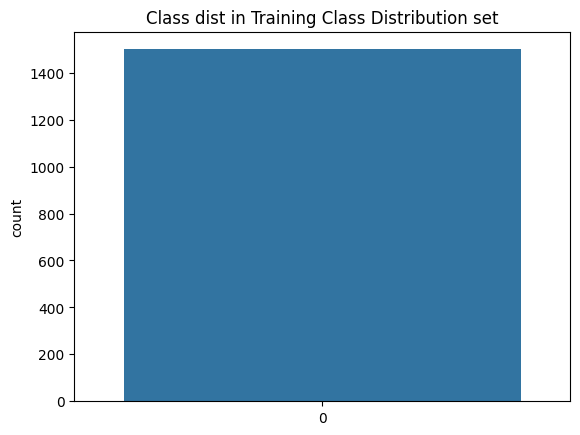

Running the model on CUDA


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at zhihan1996/DNA_bert_3 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


zhihan1996/DNA_bert_3 loaded


In [ ]:
############################################
### Reading the training and test data ####
############################################

KMER = 3  # The length of the K-mers to be used by the model and tokenizer

training_data_path = Path("/kaggle/input/covid-deeppredictor/TrainingData/Trainingdata.csv")
eval_data_path = Path("/kaggle/input/covid-deeppredictor/TestData/TestData/Testdata-2.csv")

df_training = pd.read_csv(training_data_path)

train_kmers, labels_train = [], []
for seq, label in zip(df_training["SEQ"], df_training["CLASS"]):
    kmer_seq = return_kmer(seq, K=KMER)
    train_kmers.append(kmer_seq)
    labels_train.append(label - 1)

NUM_CLASSES = len(np.unique(labels_train))

count_plot(labels_train, "Training Class Distribution")

model_config = {
    "model_path": f"zhihan1996/DNA_bert_{KMER}",
    "num_classes": NUM_CLASSES,
}

model, tokenizer, device = load_model(model_config, return_model=True)

In [ ]:
SEQ_MAX_LEN = 512  # max len of BERT

train_encodings = tokenizer.batch_encode_plus(
    train_kmers,
    max_length=SEQ_MAX_LEN,
    padding=True,  # pad to max len
    truncation=True,  # truncate to max len
    return_attention_mask=True,
    return_tensors="pt",  # return pytorch tensors
)
train_dataset = HF_dataset(
    train_encodings["input_ids"], train_encodings["attention_mask"], labels_train
)

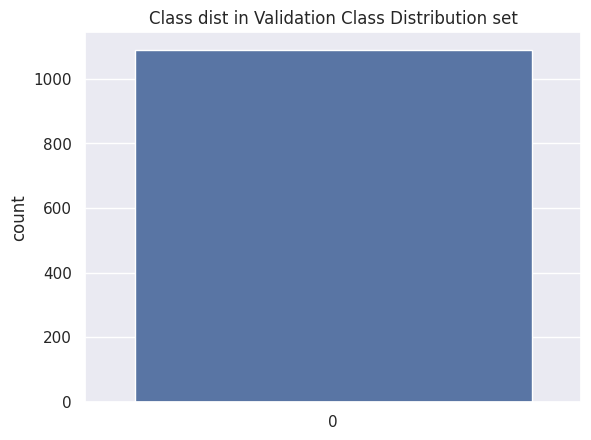

In [ ]:
df_val = pd.read_csv(eval_data_path)  # i use the Testdata-2 as the validation set

val_kmers, labels_val = [], []
for seq, label in zip(df_val["SEQ"], df_val["CLASS"]):
    kmer_seq = return_kmer(seq, K=KMER)
    val_kmers.append(kmer_seq)
    labels_val.append(label - 1)

count_plot(labels_val, "Validation Class Distribution")

In [ ]:
val_encodings = tokenizer.batch_encode_plus(
    val_kmers,
    max_length=SEQ_MAX_LEN,
    padding=True,  # pad to max len
    truncation=True,  # truncate to max len
    return_attention_mask=True,
    return_tensors="pt",  # return pytorch tensors
)
val_dataset = HF_dataset(
    val_encodings["input_ids"], val_encodings["attention_mask"], labels_val
)

### Training and eval

In [ ]:
############################################
### Training and evaluating the model #####
############################################

results_dir = Path("./results/classification/")
results_dir.mkdir(parents=True, exist_ok=True)
EPOCHS = 1
BATCH_SIZE = 8

# initialize wandb for logging the training process
wandb.init(project="DNA_bert", name=model_config["model_path"])
wandb.config.update(model_config)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
training_args = TrainingArguments(
    output_dir=results_dir / "checkpoints",  # output directory
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,  # number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # L2 regularization lambda value
    logging_steps=60,  # log metrics every 60 steps
    load_best_model_at_end=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,  # compute metrics function is used for evaluation at the end of each epoch
    tokenizer=tokenizer,
)

trainer.train()

/tmp/ipykernel_32/3704363462.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(self.input_ids[index]),
/tmp/ipykernel_32/3704363462.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(self.attention_masks[index]),
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.371800,0.351774,0.870642,0.918431,0.870642,0.853881


TrainOutput(global_step=188, training_loss=1.064903625465454, metrics={'train_runtime': 102.7311, 'train_samples_per_second': 14.601, 'train_steps_per_second': 1.83, 'total_flos': 394680757248000.0, 'train_loss': 1.064903625465454, 'epoch': 1.0})

In [ ]:
import gc

In [ ]:
torch.cuda.empty_cache()
obj=None
gc.collect()

16649

In [ ]:
from pynvml.smi import nvidia_smi
nvsmi = nvidia_smi.getInstance()
nvsmi.DeviceQuery('memory.free, memory.total')

{'gpu': [{'fb_memory_usage': {'total': 16280.875,
    'free': 14231.75,
    'unit': 'MiB'}}]}

In [ ]:
# save the model and tokenizer
model_path = results_dir / "model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

# evaluate on all the test datasets
eval_results = []
for val_dataset in val_dataset_generator(
    tokenizer, kmer_size=KMER, val_dir="/kaggle/input/covid-deeppredictor/TestData/TestData"
):
    res = trainer.evaluate(val_dataset)
    eval_results.append(res)
    torch.cuda.empty_cache()
    obj=None
    gc.collect()
    break

Testdata-1.csv 3143


/tmp/ipykernel_32/3704363462.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(self.input_ids[index]),
/tmp/ipykernel_32/3704363462.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(self.attention_masks[index]),


### Metrics

In [ ]:
# average over the eval_accuracy and eval_f1 from the dic items in eval_results
avg_acc = np.mean([res["eval_accuracy"] for res in eval_results])
avg_f1 = np.mean([res["eval_f1"] for res in eval_results])

print(f"Average accuracy: {avg_acc}")
print(f"Average F1: {avg_f1}")

wandb.log({"avg_acc": avg_acc, "avg_f1": avg_f1})
wandb.finish()

Average accuracy: 0.9914094813872096
Average F1: 0.991562172469572


avg_acc,▁
avg_f1,▁
eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▄████


# classical ML models

In [ ]:
df_training.shape

(1500, 5)

In [ ]:
df_val.shape

(1090, 4)

In [ ]:
df_val_2= pd.read_csv('/kaggle/input/covid-deeppredictor/TestData/TestData/Testdata-4.csv')

In [ ]:
df_val_2.shape

(3500, 3)

Text(0.5, 1.0, 'Class distribution of DNA')

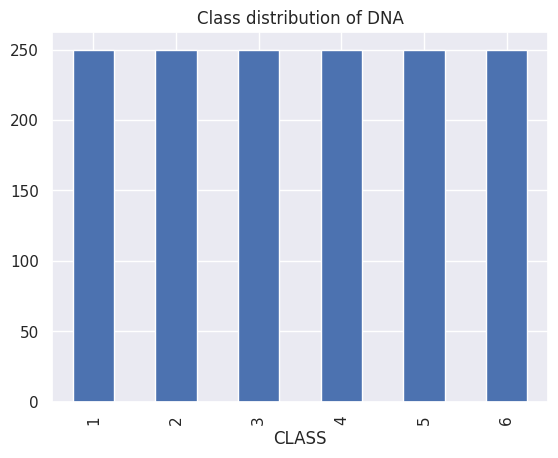

In [ ]:
sns.set()
df_training['CLASS'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of DNA")

Text(0.5, 1.0, 'Class distribution of DNA')

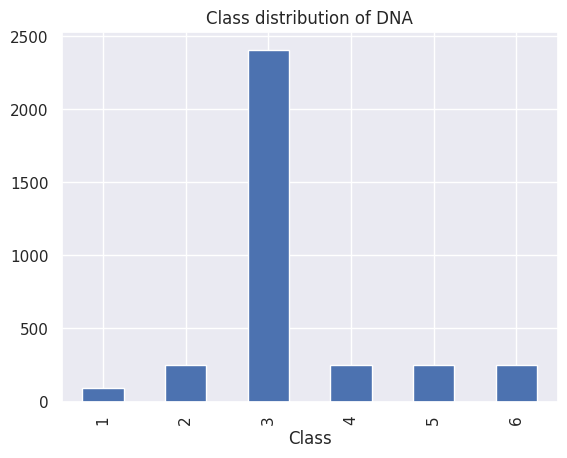

In [ ]:
sns.set()
df_val_2['Class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of DNA")

In [ ]:
def Kmers_funct(seq, size=6):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

#convert our training data sequences into short overlapping k-mers of length 6.
#Lets do that for each species of data we have using our Kmers_funct function.

virus_dna = df_training
virus_dna_val = df_val_2
virus_dna['words'] = virus_dna.apply(lambda x: Kmers_funct(x['SEQ']), axis=1)
virus_dna_val['words'] = virus_dna_val.apply(lambda x: Kmers_funct(x['SEQ']), axis=1)
virus_dna = virus_dna.drop('SEQ', axis=1)
virus_dna_val = virus_dna_val.drop('SEQ', axis=1)

In [ ]:
virus_texts = list(virus_dna['words'])
for item in range(len(virus_texts)):
    virus_texts[item] = ' '.join(virus_texts[item])
#separate labels
y_virus = virus_dna.iloc[:, 1].values # y_virus for virus_dna

In [ ]:
virus_texts_val = list(virus_dna_val['words'])
for item in range(len(virus_texts_val)):
    virus_texts_val[item] = ' '.join(virus_texts_val[item])
#separate labels
y_virus_val = virus_dna_val.iloc[:, 1].values # y_virus for virus_dna

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4)) #The n-gram size of 4 is previously determined by testing
X = cv.fit_transform(virus_texts)
X_val = cv.fit_transform(virus_texts_val)

In [ ]:
X.shape  (1090, 190994)

(1500, 173952)

In [ ]:
X_val.shape

(3500, 196888)

In [ ]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                     y_virus,
#                                                     test_size = 0.35,
#                                                     random_state=42)
X_train=X
X_test=X_val
y_train=y_virus
y_test= y_virus_val

In [ ]:
X_test = X_test[:, :X_train.shape[1]]

In [ ]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [ ]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

Confusion matrix for predictions on virus test DNA sequence

accuracy = 0.072 
precision = 0.017 
recall = 0.072 
f1 = 0.027


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


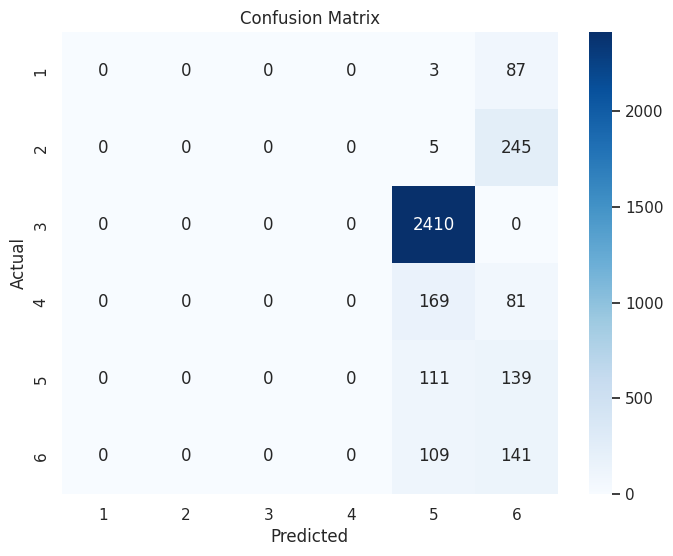

In [ ]:
print("Confusion matrix for predictions on virus test DNA sequence\n")
# print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
plt.figure(figsize=(8, 6))
confusion_matrix_data = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_data, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# from sklearn.linear_model import LogisticRegression

# lr = LogisticRegression()
# lr.fit(X_train, y_train)
# y_pred = lr.predict(X_test)
# print("Confusion matrix for predictions on virus test DNA sequence\n")
# # print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
# accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
# print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
# plt.figure(figsize=(8, 6))
# confusion_matrix_data = confusion_matrix(y_test, y_pred)
# sns.heatmap(confusion_matrix_data, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Confusion matrix for predictions on virus test DNA sequence

accuracy = 0.042 
precision = 0.004 
recall = 0.042 
f1 = 0.006


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


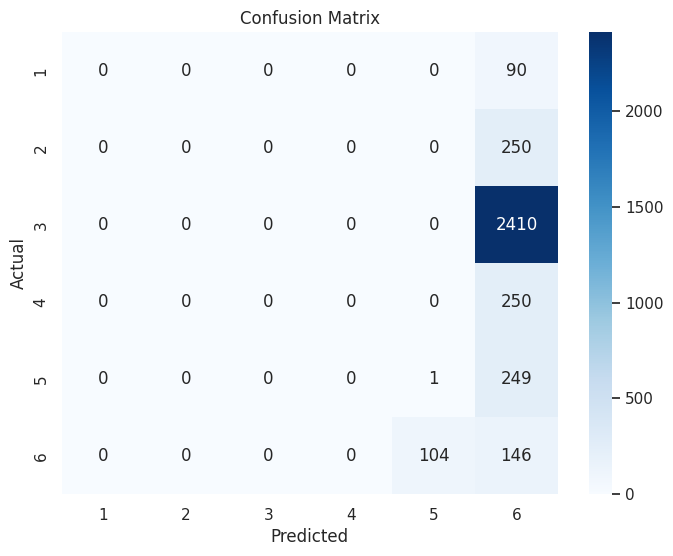

In [ ]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print("Confusion matrix for predictions on virus test DNA sequence\n")
# print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
plt.figure(figsize=(8, 6))
confusion_matrix_data = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_data, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Confusion matrix for predictions on virus test DNA sequence

accuracy = 0.071 
precision = 0.005 
recall = 0.071 
f1 = 0.010


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


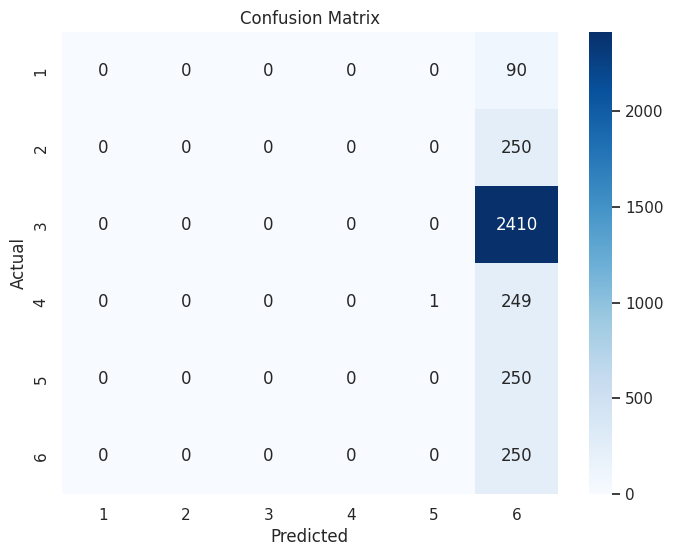

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print("Confusion matrix for predictions on virus test DNA sequence\n")
# print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
plt.figure(figsize=(8, 6))
confusion_matrix_data = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_data, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Confusion matrix for predictions on virus test DNA sequence

accuracy = 0.071 
precision = 0.005 
recall = 0.071 
f1 = 0.010


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


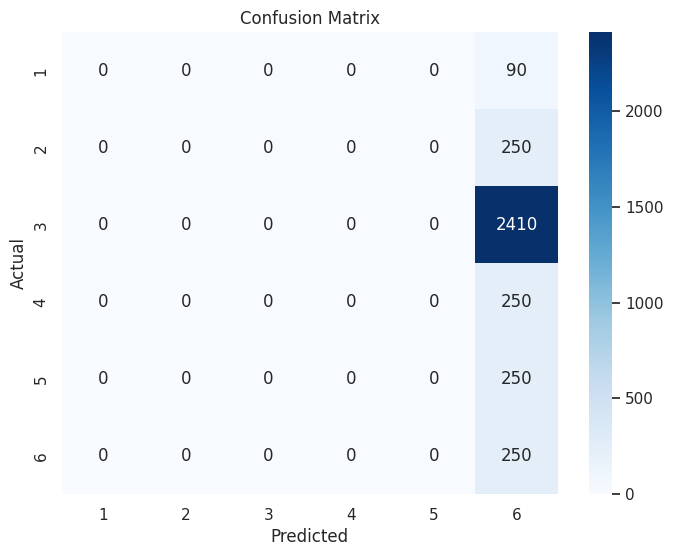

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Confusion matrix for predictions on virus test DNA sequence\n")
# print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
plt.figure(figsize=(8, 6))
confusion_matrix_data = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_data, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Confusion matrix for predictions on virus test DNA sequence

accuracy = 0.071 
precision = 0.005 
recall = 0.071 
f1 = 0.010


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


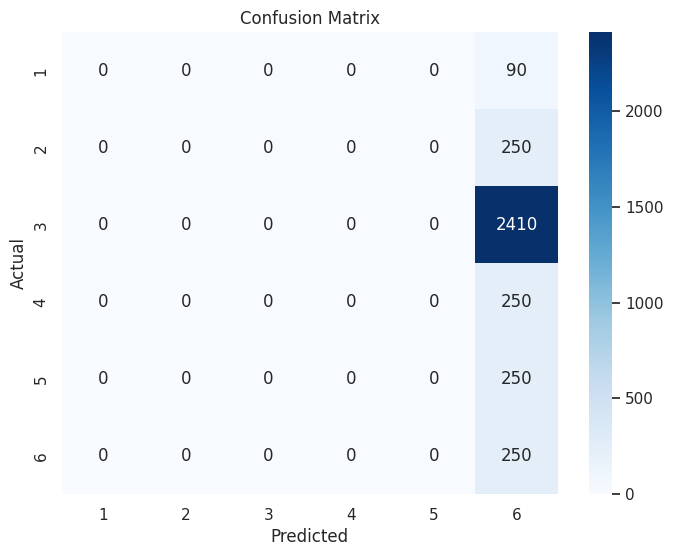

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Confusion matrix for predictions on virus test DNA sequence\n")
# print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
plt.figure(figsize=(8, 6))
confusion_matrix_data = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_data, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()